In [1]:
import os
import warnings
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime as dt
import math
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from sklearn.ensemble import RandomForestRegressor

## Loading the data into the pandas dataframe

In [2]:
df=pd.read_csv("eth_15min.csv")
df=df.rename(columns={'Unnamed: 0': 'timestamp'})
df=df.set_index("timestamp")
df

,Count,Open,High,Low,Close,Volume,VWAP,Final_Target
timestamp,,,,,,,,
2018-01-02 00:00:00,0.003662,0.157535,0.157614,0.157065,0.157601,0.002832,0.157564,0.546330
2018-01-02 00:15:00,0.004162,0.158662,0.158642,0.158646,0.158811,0.004279,0.158740,0.550354
2018-01-02 00:30:00,0.006054,0.159892,0.159816,0.160115,0.160083,0.008870,0.160017,0.635160
2018-01-02 00:45:00,0.010403,0.162664,0.162634,0.162281,0.162819,0.013069,0.162755,0.532988
2018-01-02 01:00:00,0.009185,0.163607,0.163588,0.163585,0.163808,0.016034,0.163705,0.566638
...,...,...,...,...,...,...,...,...
2021-09-20 23:15:00,0.106084,0.678958,0.678254,0.679382,0.678950,0.033112,0.679075,0.490194
2021-09-20 23:30:00,0.098318,0.674762,0.673794,0.675055,0.674654,0.030090,0.674565,0.455695
2021-09-20 23:45:00,0.087173,0.673576,0.672953,0.674331,0.673675,0.028622,0.673872,0.447677


## visualization of the final target 

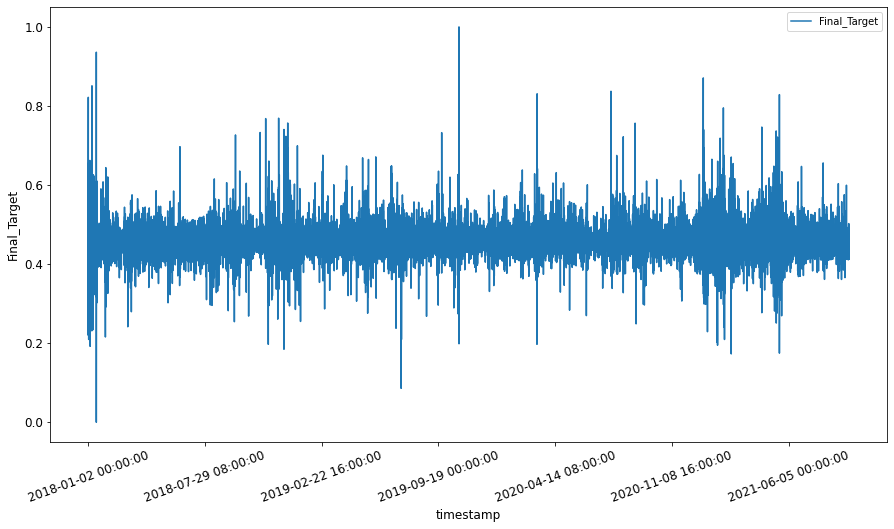

In [6]:
df.plot(y='Final_Target', subplots=True, figsize=(15, 8), fontsize=12)
plt.xlabel('timestamp', fontsize=12)
plt.ylabel('Final_Target', fontsize=12)
plt.xticks(rotation=20)
plt.show()

In [7]:
# univariate data: Final_target vs Time

uni_data_df = df['Final_Target']
uni_data_df.head()
uni_data_df.shape

(130370,)

In [8]:
uni_data_df.shape

(130370,)

In [9]:
#splitting the data into 70-30
train_start_dt = '2018-01-02'
test_start_dt = '2020-08-11'

## Data visualisation of train and test 

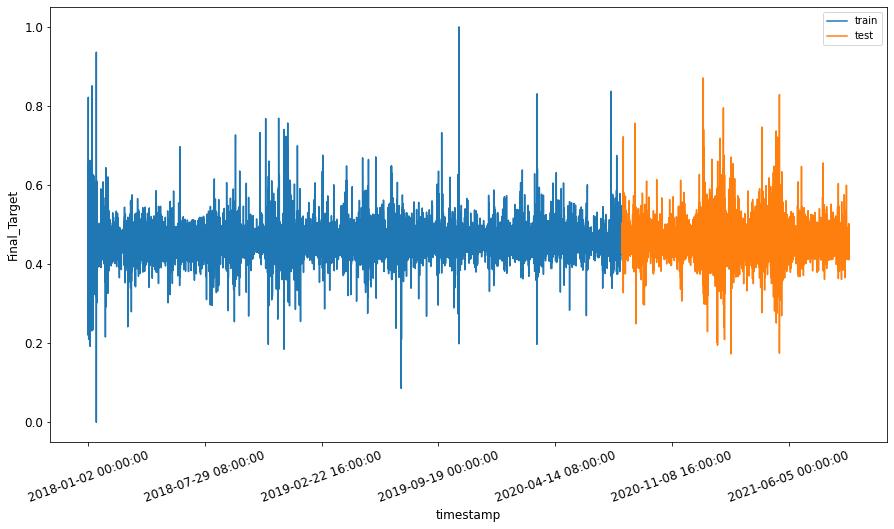

In [10]:
#data visualisation of train and test 
df[(df.index < test_start_dt) & (df.index >= train_start_dt)][['Final_Target']].rename(columns={'Final_Target':'train'}) \
    .join(df[test_start_dt:][['Final_Target']].rename(columns={'Final_Target':'test'}), how='outer') \
    .plot(y=['train', 'test'], figsize=(15, 8), fontsize=12)
plt.xlabel('timestamp', fontsize=12)
plt.ylabel('Final_Target', fontsize=12)
plt.xticks(rotation=20)
plt.show()

In [11]:
train = df.copy()[(df.index >= train_start_dt) & (df.index < test_start_dt)][['Final_Target']]
test = df.copy()[df.index >= test_start_dt][['Final_Target']]

print('Training data shape: ', train.shape)
print('Test data shape: ', test.shape)

Training data shape:  (91392, 1)
Test data shape:  (38978, 1)


In [12]:
train.head(10)

,Final_Target
timestamp,
2018-01-02 00:00:00,0.546330
2018-01-02 00:15:00,0.550354
2018-01-02 00:30:00,0.635160
2018-01-02 00:45:00,0.532988
2018-01-02 01:00:00,0.566638
2018-01-02 01:15:00,0.573950
2018-01-02 01:30:00,0.734319
2018-01-02 01:45:00,0.751294
2018-01-02 02:00:00,0.683291


In [13]:
test.shape

(38978, 1)

In [14]:
test.head(10)

,Final_Target
timestamp,
2020-08-11 00:00:00,0.427689
2020-08-11 00:15:00,0.461544
2020-08-11 00:30:00,0.441716
2020-08-11 00:45:00,0.467855
2020-08-11 01:00:00,0.462050
2020-08-11 01:15:00,0.479041
2020-08-11 01:30:00,0.458920
2020-08-11 01:45:00,0.444222
2020-08-11 02:00:00,0.466103


In [15]:
# Converting to numpy arrays
train_data = train.values
test_data = test.values

In [16]:
#using the previous past 4 time steps to predict the next time step i.e 5th min target value
timesteps=5

In [17]:
train_data_timesteps=np.array([[j for j in train_data[i:i+timesteps]] for i in range(0,len(train_data)-timesteps+1)])[:,:,0]
train_data_timesteps.shape

(91388, 5)

In [18]:
train_data_timesteps

array([[0.54632988, 0.55035361, 0.63515959, 0.53298773, 0.56663839],
       [0.55035361, 0.63515959, 0.53298773, 0.56663839, 0.57395036],
       [0.63515959, 0.53298773, 0.56663839, 0.57395036, 0.73431893],
       ...,
       [0.46315553, 0.45774441, 0.45223693, 0.45438962, 0.44349477],
       [0.45774441, 0.45223693, 0.45438962, 0.44349477, 0.44573861],
       [0.45223693, 0.45438962, 0.44349477, 0.44573861, 0.4606606 ]])

In [19]:
test_data_timesteps=np.array([[j for j in test_data[i:i+timesteps]] for i in range(0,len(test_data)-timesteps+1)])[:,:,0]
test_data_timesteps.shape

(38974, 5)

In [20]:
test_data_timesteps

array([[0.42768886, 0.46154377, 0.44171578, 0.46785507, 0.4620502 ],
       [0.46154377, 0.44171578, 0.46785507, 0.4620502 , 0.47904068],
       [0.44171578, 0.46785507, 0.4620502 , 0.47904068, 0.45891978],
       ...,
       [0.41220745, 0.45940606, 0.49019406, 0.45569509, 0.4476771 ],
       [0.45940606, 0.49019406, 0.45569509, 0.4476771 , 0.45339031],
       [0.49019406, 0.45569509, 0.4476771 , 0.45339031, 0.45339031]])

In [21]:
x_train, y_train = train_data_timesteps[:,:timesteps-1],train_data_timesteps[:,[timesteps-1]]
x_test, y_test = test_data_timesteps[:,:timesteps-1],test_data_timesteps[:,[timesteps-1]]

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(91388, 4) (91388, 1)
(38974, 4) (38974, 1)


In [22]:
x_train,y_train

(array([[0.54632988, 0.55035361, 0.63515959, 0.53298773],
        [0.55035361, 0.63515959, 0.53298773, 0.56663839],
        [0.63515959, 0.53298773, 0.56663839, 0.57395036],
        ...,
        [0.46315553, 0.45774441, 0.45223693, 0.45438962],
        [0.45774441, 0.45223693, 0.45438962, 0.44349477],
        [0.45223693, 0.45438962, 0.44349477, 0.44573861]]),
 array([[0.56663839],
        [0.57395036],
        [0.73431893],
        ...,
        [0.44349477],
        [0.44573861],
        [0.4606606 ]]))

In [23]:
x_test, y_test

(array([[0.42768886, 0.46154377, 0.44171578, 0.46785507],
        [0.46154377, 0.44171578, 0.46785507, 0.4620502 ],
        [0.44171578, 0.46785507, 0.4620502 , 0.47904068],
        ...,
        [0.41220745, 0.45940606, 0.49019406, 0.45569509],
        [0.45940606, 0.49019406, 0.45569509, 0.4476771 ],
        [0.49019406, 0.45569509, 0.4476771 , 0.45339031]]),
 array([[0.4620502 ],
        [0.47904068],
        [0.45891978],
        ...,
        [0.4476771 ],
        [0.45339031],
        [0.45339031]]))

## Model training

In [25]:
# Train the model
model = RandomForestRegressor().fit(x_train, y_train)
model.fit(x_train, y_train)

/tmp/ipykernel_479/1991629724.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model = RandomForestRegressor().fit(x_train, y_train)
/tmp/ipykernel_479/1991629724.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(x_train, y_train)


RandomForestRegressor()

In [26]:
y_train_pred = model.predict(x_train).reshape(-1,1)
y_test_pred = model.predict(x_test).reshape(-1,1)

print(y_train_pred.shape, y_test_pred.shape)

(91388, 1) (38974, 1)


In [27]:
train_timestamps = df[(df.index < test_start_dt) & (df.index >= train_start_dt)].index[timesteps-1:]
test_timestamps = df[test_start_dt:].index[timesteps-1:]

print(len(train_timestamps), len(test_timestamps))

91388 38974


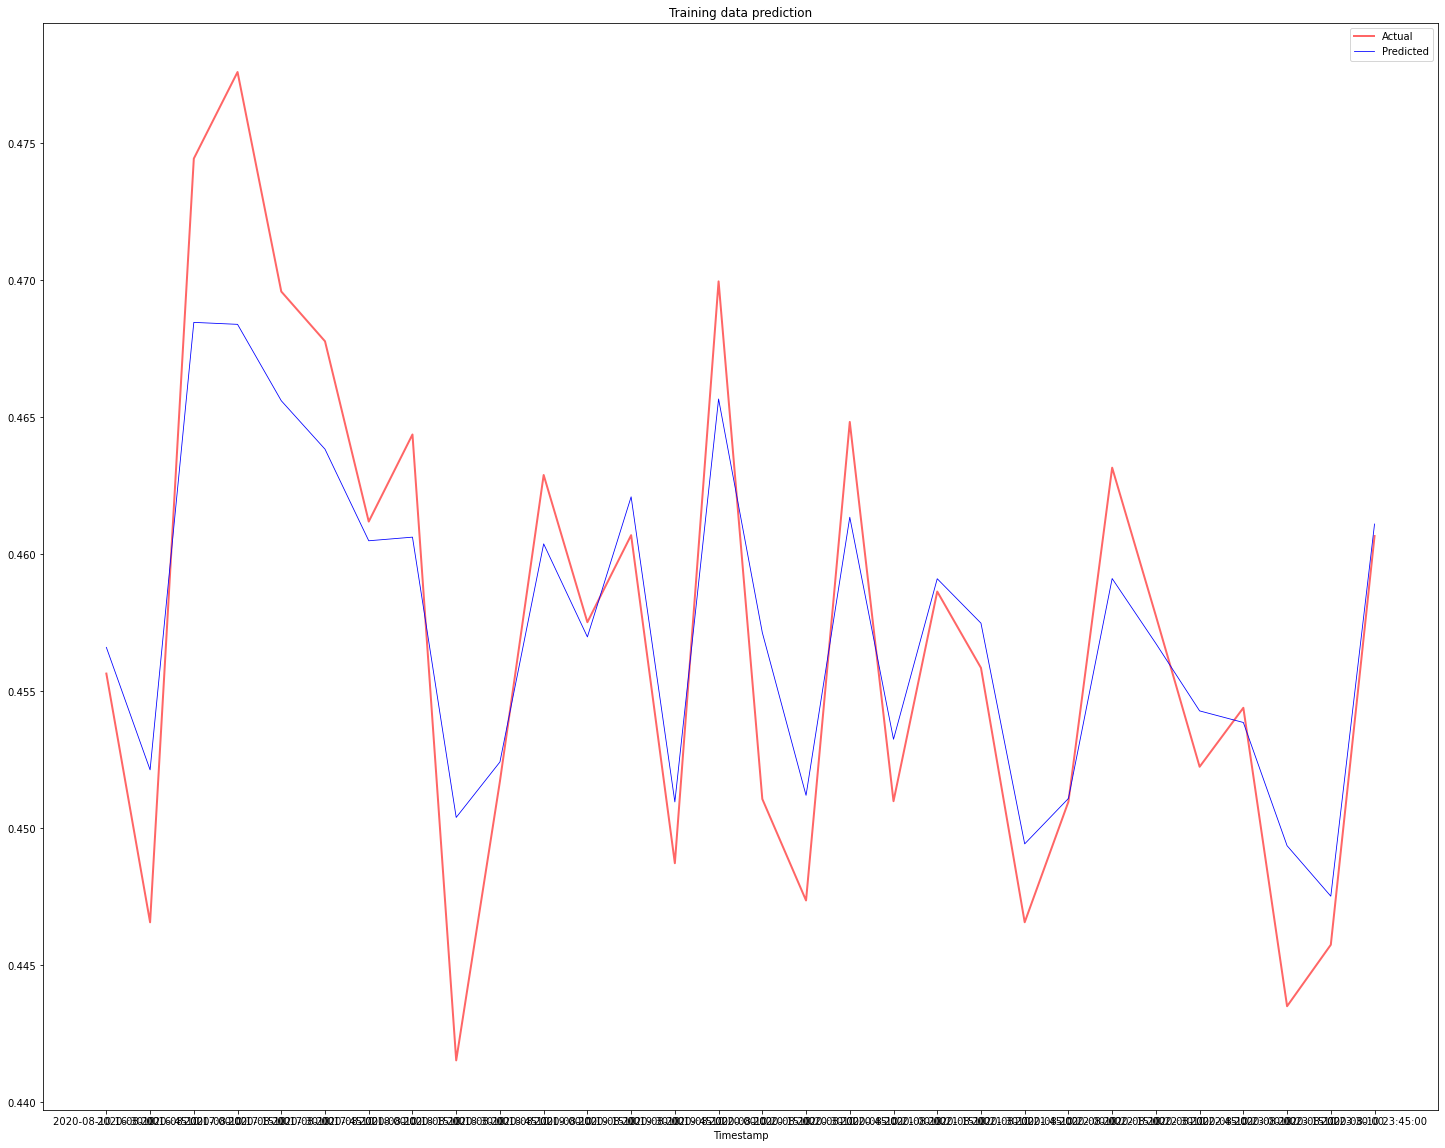

In [28]:
plt.figure(figsize=(25,20))
plt.plot(train_timestamps[-30:], y_train[-30:], color = 'red', linewidth=2.0, alpha = 0.6)
plt.plot(train_timestamps[-30:], y_train_pred[-30:], color = 'blue', linewidth=0.8)
plt.legend(['Actual','Predicted'])
plt.xlabel('Timestamp')
plt.title("Training data prediction")
plt.xticks(rotation=20)
plt.show()

In [29]:
def percentage_error(actual, predicted):
    res = np.empty(actual.shape)
    for j in range(actual.shape[0]):
        if actual[j] != 0:
            res[j] = (actual[j] - predicted[j]) / actual[j]
        else:
            res[j] = predicted[j] / np.mean(actual)
    return res

def mean_absolute_percentage_error1(y_true, y_pred): 
    return np.mean(np.abs(percentage_error(np.asarray(y_true), np.asarray(y_pred)))) * 100

In [30]:
mean_absolute_percentage_error1(y_test,y_test_pred)

3.819437407461363

In [31]:
mean_absolute_percentage_error1(y_train,y_train_pred)

1.15504010115111

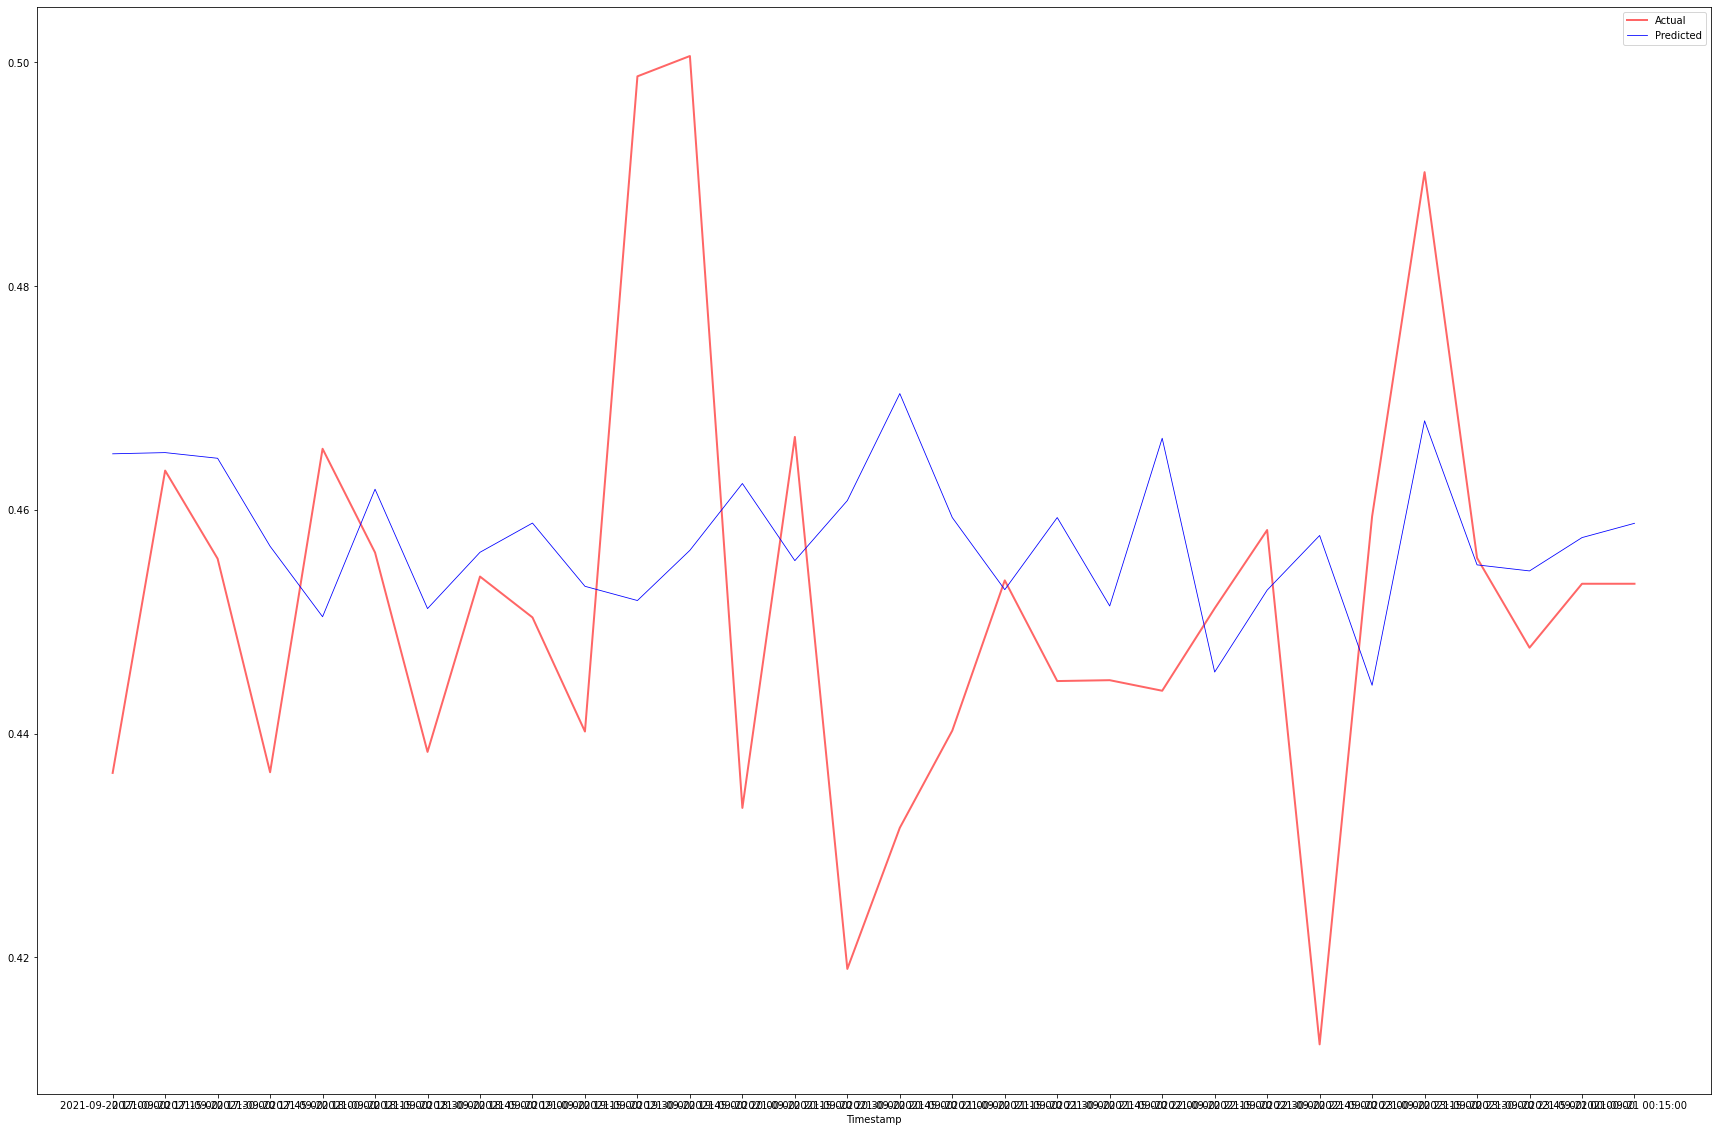

In [32]:
plt.figure(figsize=(30,20))
plt.plot(test_timestamps[-30:], y_test[-30:], color = 'red', linewidth=2.0, alpha = 0.6)
plt.plot(test_timestamps[-30:], y_test_pred[-30:], color = 'blue', linewidth=0.8)
plt.legend(['Actual','Predicted'])
plt.xlabel('Timestamp')
plt.show()

In [33]:
mse = mean_squared_error(y_test, y_test_pred)
print("MSE:", mse)
rmse = np.sqrt(mse)
print("RMSE:", rmse)

MSE: 0.0007065911084600181
RMSE: 0.026581781514037357


In [34]:
mse = mean_squared_error(y_train, y_train_pred)
print("MSE:", mse)
rmse = np.sqrt(mse)
print("RMSE:", rmse)

MSE: 6.849256785158138e-05
RMSE: 0.00827602367393795


## Hyperparameter tuning

In [31]:
# calculating different regression metrics

from scipy.stats import randint
from sklearn.model_selection import RandomizedSearchCV

np.random.seed(0)
param_dist = {'bootstrap': [True],
    'max_depth': [80, 90, 100, 110],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 1000]}
tuning_model=RandomizedSearchCV(model,param_dist,scoring='neg_mean_absolute_percentage_error',cv=3,verbose=3,error_score='raise')

tuning_model.fit(x_train,y_train[:,0])

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV 1/3] END bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=1000;, score=-0.071 total time=   2.4s
[CV 2/3] END bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=1000;, score=-0.071 total time=   2.5s
[CV 3/3] END bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=1000;, score=-0.054 total time=   2.4s
[CV 1/3] END bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=300;, score=-0.071 total time=   0.7s
[CV 2/3] END bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=300;, score=-0.071 total time=   0.8s
[CV 3/3] END bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=300;, score=-0.054 total time=   0.7s
[CV 1/3] END bootstrap=T

RandomizedSearchCV(cv=3, error_score='raise', estimator=RandomForestRegressor(),
                   param_distributions={'bootstrap': [True],
                                        'max_depth': [80, 90, 100, 110],
                                        'max_features': [2, 3],
                                        'min_samples_leaf': [3, 4, 5],
                                        'min_samples_split': [8, 10, 12],
                                        'n_estimators': [100, 200, 300, 1000]},
                   scoring='neg_mean_absolute_percentage_error', verbose=3)

In [32]:
tuning_model.best_params_

{'n_estimators': 100,
 'min_samples_split': 8,
 'min_samples_leaf': 5,
 'max_features': 2,
 'max_depth': 110,
 'bootstrap': True}

In [35]:
tuned_rf_model= RandomForestRegressor(bootstrap=True,max_depth=110,max_features=2,min_samples_leaf=5,
                                      min_samples_split=8,n_estimators=100)


tuned_rf_model.fit(x_train,y_train)

/tmp/ipykernel_479/2169453953.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  tuned_rf_model.fit(x_train,y_train)


RandomForestRegressor(max_depth=110, max_features=2, min_samples_leaf=5,
                      min_samples_split=8)

In [36]:
y_train_pred1 = tuned_rf_model.predict(x_train).reshape(-1,1)
y_test_pred1 = tuned_rf_model.predict(x_test).reshape(-1,1)

print(y_train_pred1.shape, y_test_pred1.shape)

(91388, 1) (38974, 1)


In [37]:
train_timestamps1 = df[(df.index < test_start_dt) & (df.index >= train_start_dt)].index[timesteps-1:]
test_timestamps1 = df[test_start_dt:].index[timesteps-1:]

print(len(train_timestamps1), len(test_timestamps1))

91388 38974


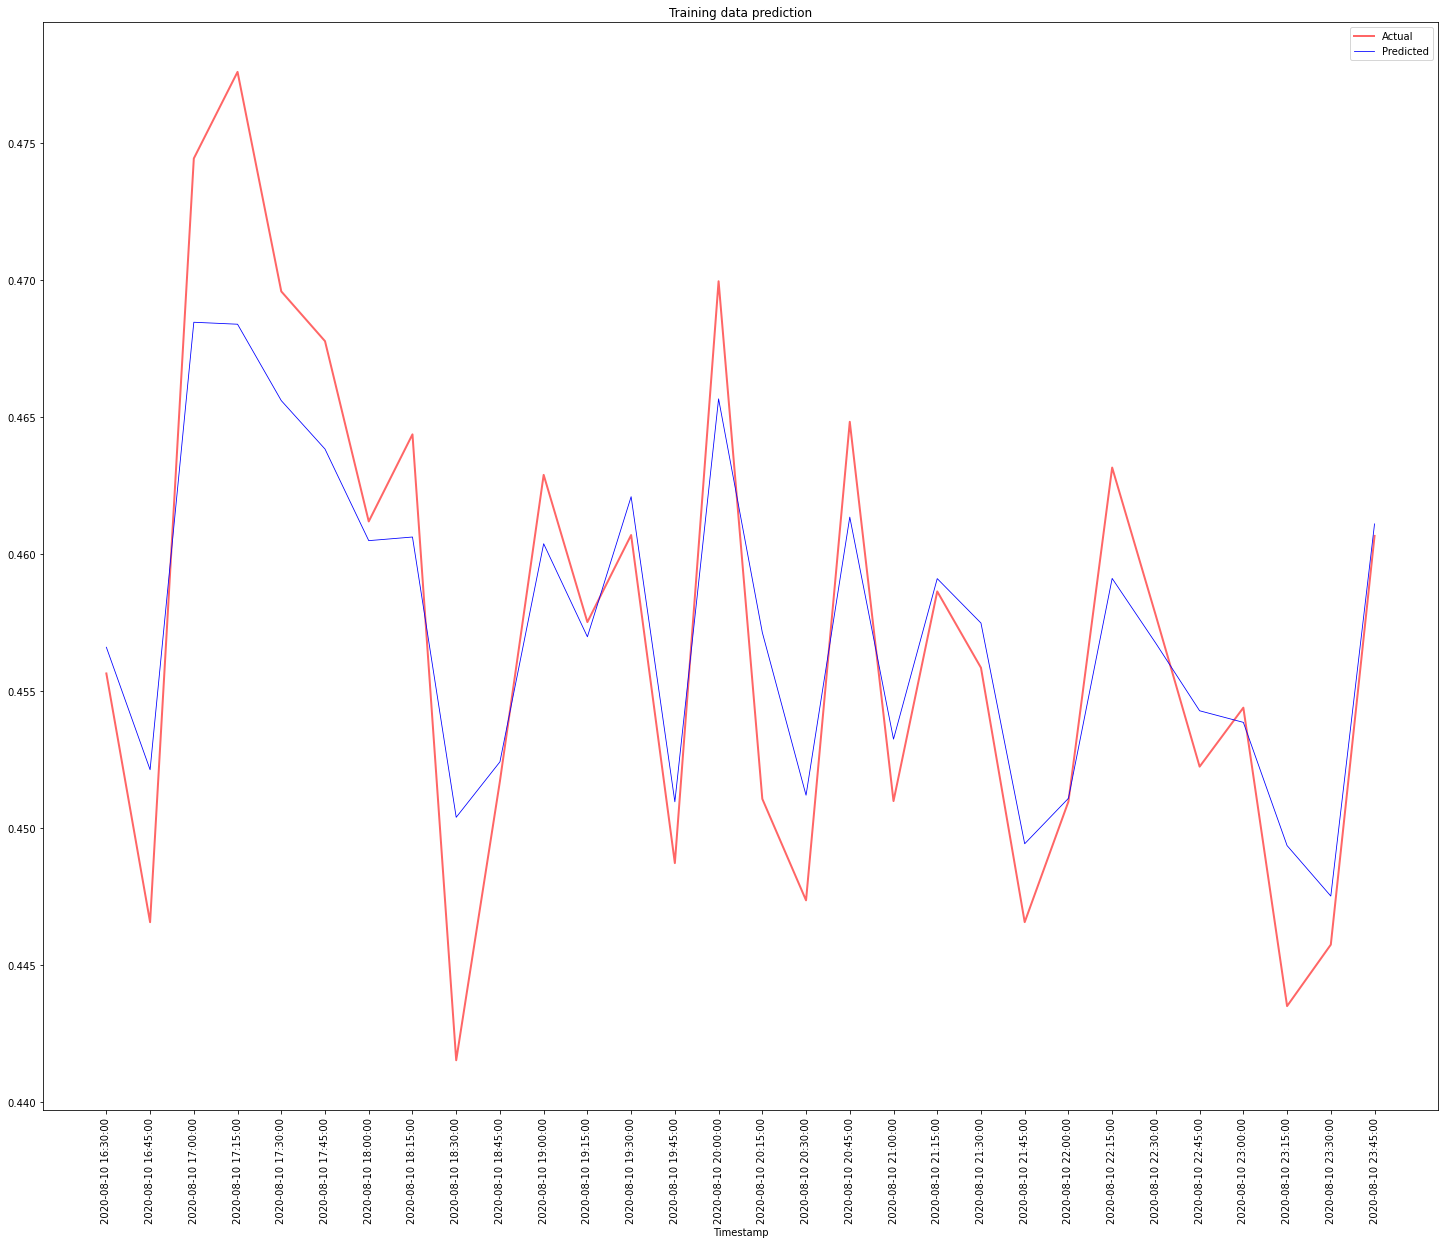

In [38]:
#Visulising the actual vs predicted for the last 30 values in the Train data
plt.figure(figsize=(25,20))
plt.plot(train_timestamps[-30:], y_train[-30:], color = 'red', linewidth=2.0, alpha = 0.6)
plt.plot(train_timestamps[-30:], y_train_pred[-30:], color = 'blue', linewidth=0.8)
plt.legend(['Actual','Predicted'])
plt.xlabel('Timestamp')
plt.title("Training data prediction")
plt.xticks(rotation=90)
plt.show()

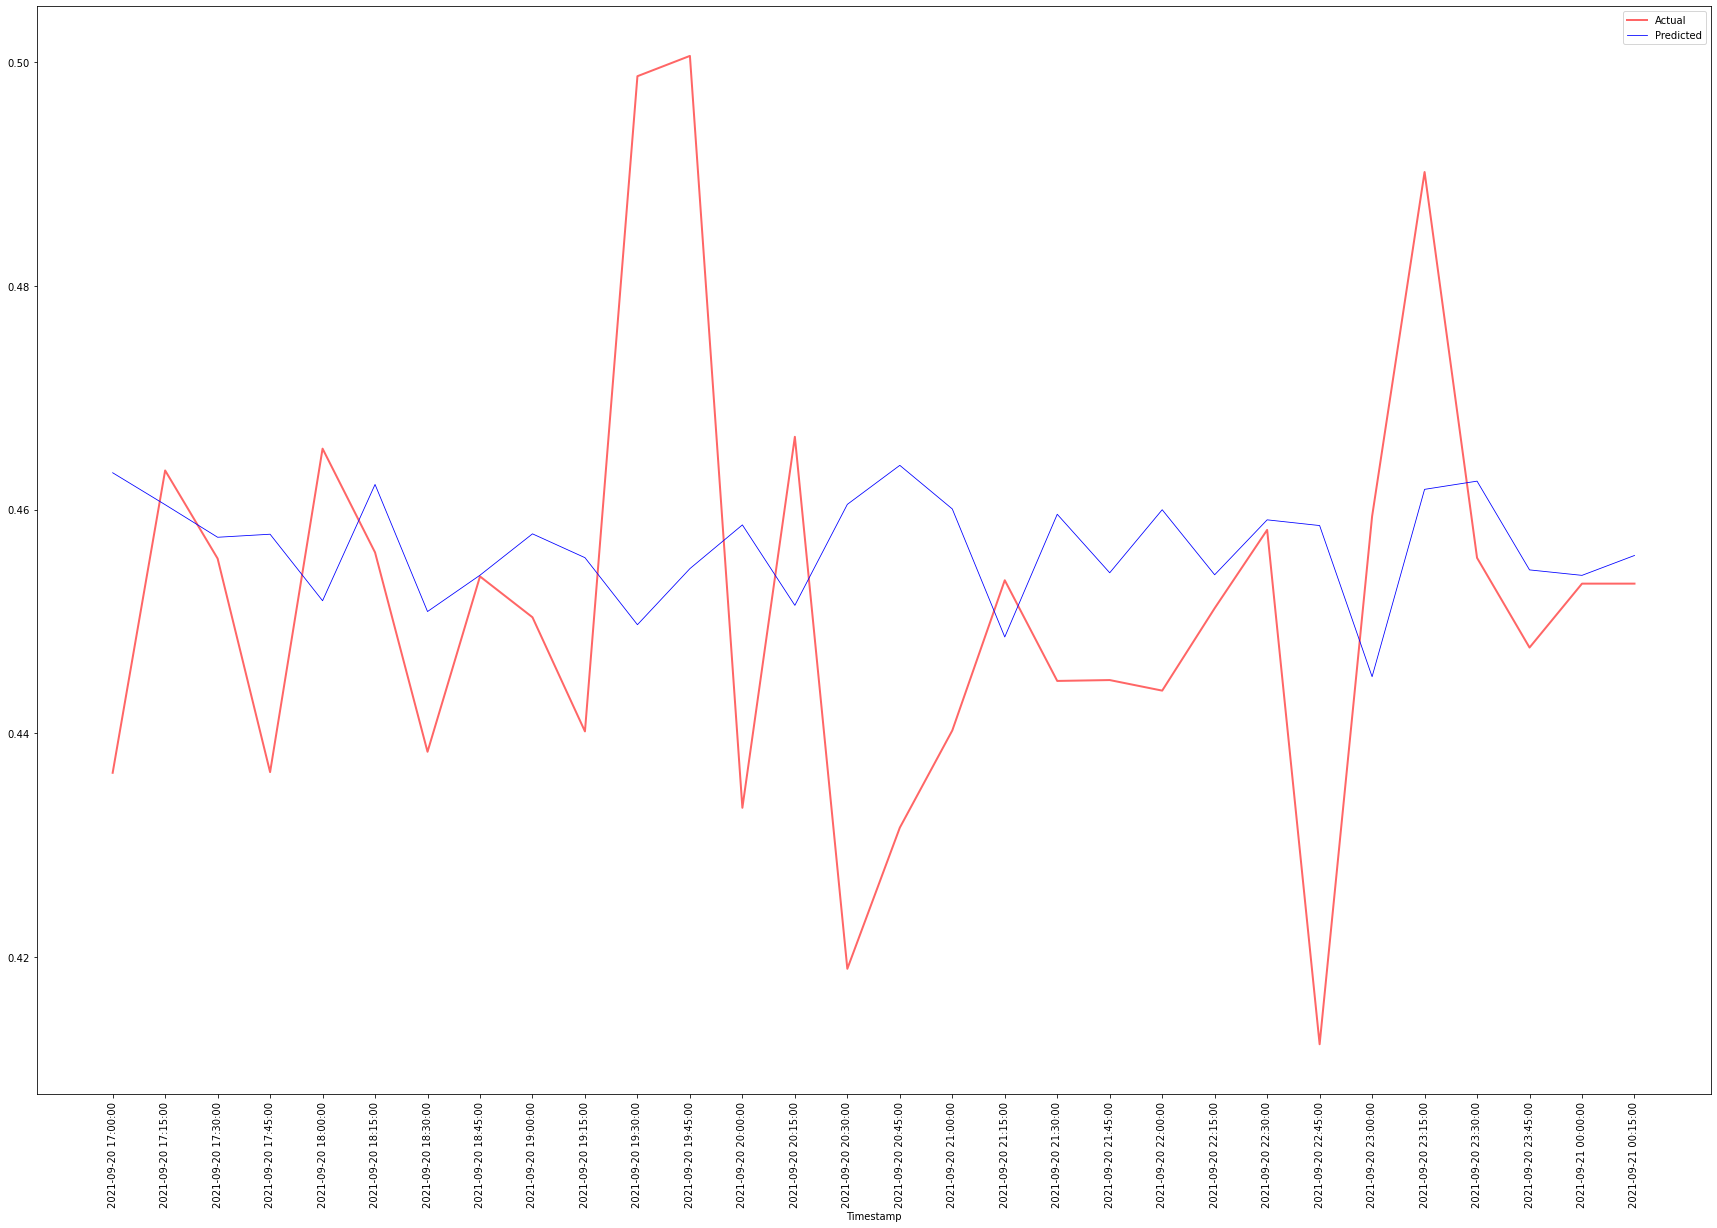

In [39]:
#Visulising the actual vs predicted for the last 30 values in the TEST data
plt.figure(figsize=(30,20))
plt.plot(test_timestamps[-30:], y_test[-30:], color = 'red', linewidth=2.0, alpha = 0.6)
plt.plot(test_timestamps[-30:], y_test_pred1[-30:], color = 'blue', linewidth=0.8)
plt.legend(['Actual','Predicted'])
plt.xlabel('Timestamp')
plt.xticks(rotation=90)
plt.show()

In [40]:
#TEST MAPE
mean_absolute_percentage_error1(y_test,y_test_pred1)

3.738563874357602

In [41]:
#train MAPE
mean_absolute_percentage_error1(y_train,y_train_pred1)

2.1772426490907404

In [42]:
print('MSE:', mean_squared_error(y_test,y_test_pred1))
print('RMSE:', np.sqrt(mean_squared_error(y_test,y_test_pred1)))

MSE: 0.0006795848695164836
RMSE: 0.026068848641942043


In [43]:
print('MSE:', mean_squared_error(y_train,y_train_pred1))
print('RMSE:', np.sqrt(mean_squared_error(y_train,y_train_pred1)))

MSE: 0.0002596574392444986
RMSE: 0.016113889637343885
